## FB15k-237 semantic graph

https://www.kaggle.com/datasets/latebloomer/fb15k-237/data

https://www.kaggle.com/datasets/latebloomer/freebase-wikidata-mapping

In [232]:
!pip install kagglehub

In [3]:
import kagglehub

# path = kagglehub.dataset_download("latebloomer/fb15k-237")
# print("Path to dataset files:", path)

In [4]:
import pandas as pd
import numpy as np

In [5]:
data_path = "../datasets/fb15k-237/"

### Load triples and augment from source

### Load augmented triples directly

In [6]:
relations_df = pd.read_csv(f"{data_path}/derived/relations_with_ids.csv")

In [7]:
relations_df.head()

,relation_name,relation_id
0,/location/country/form_of_government,0
1,/tv/tv_program/regular_cast./tv/regular_tv_app...,1
2,/media_common/netflix_genre/titles,2
3,/award/award_winner/awards_won./award/award_ho...,3
4,/soccer/football_team/current_roster./sports/s...,4


In [8]:
freebase_vs_wiki_df =  pd.read_csv(f"{data_path}/fb_wiki_mapping.tsv", sep='\t')
# freebase_vs_wiki_df =  pd.read_csv(f"{data_path}/fb_wiki_mapping.csv")

In [9]:
# freebase_vs_wiki_df[''] = df.index
freebase_vs_wiki_df.head(3)

,freebase_id,wikidata_id,label
0,/m/010005,Q974334,Corinth
1,/m/01000j,Q981582,Draper
2,/m/01000w,Q977417,Cross Roads


In [10]:
freebase_vs_wiki_df.describe()

,freebase_id,wikidata_id,label
count,2096636,2096636,2095837
unique,2094552,2096636,1959699
top,/m/060gfy,Q974334,Central District
freq,3,1,373


In [11]:
# strip Q from wikidata id for easier use with Kumo AI
freebase_vs_wiki_df['wikidata_int_id'] = freebase_vs_wiki_df.apply(lambda row: int(row['wikidata_id'][1:]), axis=1)

In [12]:
freebase_vs_wiki_df.drop('wikidata_id', axis=1, inplace=True)
freebase_vs_wiki_df.rename(columns={'wikidata_int_id':'wikidata_id'}, inplace=True)

In [87]:
triplets_with_src_dst_wiki_ids_df = pd.read_csv(f"{data_path}/exp2/triplets_with_src_dst_wiki_ids.csv")

In [142]:
df_test = pd.read_csv(f"{data_path}/exp2/triplets_with_src_dst_wiki_ids.test.csv")

In [127]:
triplets_with_src_dst_wiki_ids_df['inaccurate'] = triplets_with_src_dst_wiki_ids_df['inaccurate'].astype('bool')
df_test['inaccurate'] = df_test['inaccurate'].astype('bool')

In [156]:
## Reset label for test samples to 
# df_test['inaccurate'] = False
# df_test['inaccurate'] = '0.2'

# df_test.inaccurate.value_counts()

inaccurate
0    14630
1     3656
Name: count, dtype: int64

In [150]:
combined_triplets = pd.concat([triplets_with_src_dst_wiki_ids_df, df_test])

In [151]:
# combined_triplets['inaccurate'] = combined_triplets['inaccurate'].astype('float')
combined_triplets[['inaccurate']].value_counts()

inaccurate
0             208993
1              52382
Name: count, dtype: int64

In [152]:
combined_triplets['timestamp'] = pd.to_datetime(combined_triplets['timestamp'])
# combined_triplets['inaccurate'] = combined_triplets['inaccurate'].astype('bool')

In [153]:
# triplets_with_src_dst_wiki_ids_df.info()
combined_triplets.info()

<class 'pandas.core.frame.DataFrame'>
Index: 261375 entries, 0 to 18285
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   src_freebase_id   261375 non-null  object        
 1   relation          261375 non-null  object        
 2   dest_freebase_id  261375 non-null  object        
 3   triple_id         261375 non-null  int64         
 4   timestamp         261375 non-null  datetime64[ns]
 5   relation_name     261375 non-null  object        
 6   relation_id       261375 non-null  int64         
 7   freebase_id_x     261375 non-null  object        
 8   label_x           261375 non-null  object        
 9   src_wikidata_id   261375 non-null  int64         
 10  freebase_id_y     261375 non-null  object        
 11  label_y           261375 non-null  object        
 12  dest_wikidata_id  261375 non-null  int64         
 13  inaccurate        261375 non-null  int64         
dtypes: datetim

In [154]:
# All nodes and associated triples for freebase / wiki ?
import kumoai as kumo

In [17]:
import kumoai.experimental.rfm as rfm
import os

In [18]:
if not os.environ.get("KUMO_API_KEY"):
    rfm.authenticate()

Opening browser page to automatically generate an API key...


[2025-08-20 05:35:15 - kumoai:298 - INFO] Generated token "sdk-macbook-pro-3.local-2025-08-20-05-35-11-Z" and saved to KUMO_API_KEY env variable


In [19]:
KUMO_API_KEY = os.environ.get("KUMO_API_KEY")
rfm.init(api_key=KUMO_API_KEY)

[2025-08-20 05:35:16 - kumoai:196 - INFO] Successfully initialized the Kumo SDK against deployment https://kumorfm.ai/api, with log level INFO.


In [155]:
triples = rfm.LocalTable(
    combined_triplets[['triple_id', 'src_wikidata_id', 'relation_id', 'dest_wikidata_id', 'timestamp', 'inaccurate']], 
    name="triples"
).infer_metadata()

Detected primary key 'triple_id' and time column 'timestamp' in table 'triples'


In [60]:
relations = rfm.LocalTable(
    relations_df, name="relations", primary_key='relation_id'
).infer_metadata()

In [61]:
freebase_vs_wiki1 = rfm.LocalTable(freebase_vs_wiki_df, name="freebase_vs_wiki_src", primary_key="wikidata_id").infer_metadata()

In [62]:
freebase_vs_wiki2 = rfm.LocalTable(freebase_vs_wiki_df.copy(), name="freebase_vs_wiki_dest", primary_key="wikidata_id").infer_metadata()

In [134]:
graph = rfm.LocalGraph(tables=[
    triples,
    relations,
    freebase_vs_wiki1,
    freebase_vs_wiki2,
])

In [135]:
# graph.link(src_table="freebase_vs_wiki", fkey="src_wikidata_id", dst_table="triples")
graph.link(src_table="triples", fkey="src_wikidata_id", dst_table="freebase_vs_wiki_src")

LocalGraph(
  tables=[triples, relations, freebase_vs_wiki_src, freebase_vs_wiki_dest],
  edges=[Edge(src_table='triples', fkey='src_wikidata_id', dst_table='freebase_vs_wiki_src')],
)

In [136]:
graph.link(src_table="triples",fkey="relation_id", dst_table="relations")

LocalGraph(
  tables=[triples, relations, freebase_vs_wiki_src, freebase_vs_wiki_dest],
  edges=[Edge(src_table='triples', fkey='src_wikidata_id', dst_table='freebase_vs_wiki_src'), Edge(src_table='triples', fkey='relation_id', dst_table='relations')],
)

In [137]:
graph.link(src_table="triples", fkey="dest_wikidata_id", dst_table="freebase_vs_wiki_dest")

LocalGraph(
  tables=[triples, relations, freebase_vs_wiki_src, freebase_vs_wiki_dest],
  edges=[Edge(src_table='triples', fkey='src_wikidata_id', dst_table='freebase_vs_wiki_src'), Edge(src_table='triples', fkey='relation_id', dst_table='relations'), Edge(src_table='triples', fkey='dest_wikidata_id', dst_table='freebase_vs_wiki_dest')],
)

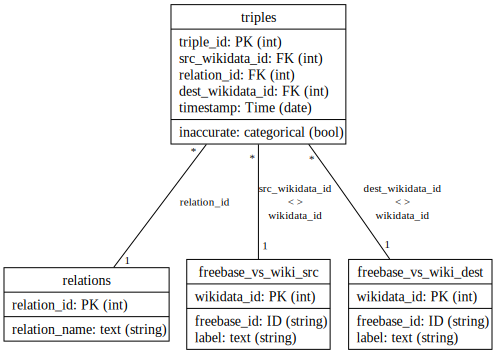

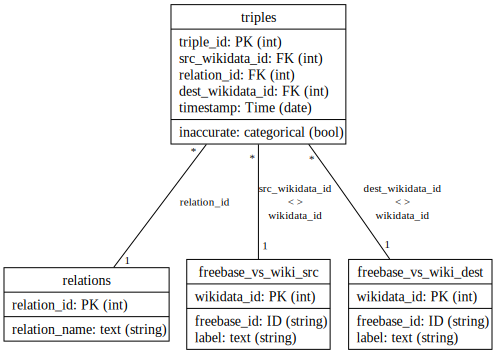

In [138]:
graph.visualize()

In [29]:
# graph['triples']['relation'].stype
# graph['triples']['relation_id'].stype

In [146]:
model = rfm.KumoRFM(graph)

Output()

In [31]:
# PREDICT triples.relation
# Couldn't pick a unique triples.relation for each freebase_vs_wiki. row 1, column 8: Encountered an error, we have found 
# multiple 'relation' values in the 'triples' table for a single 'freebase_vs_wiki'. To fix this, you have two options:
## 1. Aggregate the values: If your 'triples' table has a 'created at' column, use an aggregation function to reduce them to one value. 
##   For example: PREDICT LAST(triples.relation, 0, 30, days).
## 2. Rewrite your query: If you are writing a static node prediction predictive query, make sure that you 
##   either use the same table to define your target and entity, or you have a foreign key from the entity pointing to the target table, 
##   not the other way around.

# PREDICT triples.relation RANK TOP 10
## Problem type 'ProblemType.RANK' is only supported for multicategorical targets. . row 1, column 8: Target 'triples.relation' is 
## not multicategorical. Either drop the problem type ProblemType.RANK OR 
## change the target to a multicategorical column, 'LAST'/'FIRST' aggregation of a multicategorical column, or a 'LIST_DISTINCT' aggregation.

# FOR triples.src_wikidata_id=7413907
# Invalid entity. row 2, column 4: Entity 'triples.src_wikidata_id' is not a primary key. 
# The column used in 'FOR EACH' has to be a primary key.

# FOR 

# WHERE triples.relation contains 'place'


In [32]:
# kumo.init(api_key=KUMO_API_KEY)

In [33]:
# Working queries

query = """
PREDICT freebase_vs_wiki.freebase_id 
FOR freebase_vs_wiki.wikidata_id=7413907 
"""

query = """
PREDICT LIST_DISTINCT(triples.relation_id, 0, 80, days)
FOR freebase_vs_wiki.wikidata_id=486860 
"""

# relations / types of edges for Arnold Schwarzenegger
query = """
PREDICT LIST_DISTINCT(triples.relation_id, 0, 80, days)
FOR freebase_vs_wiki_src.wikidata_id=2685 
"""

query1 = """
PREDICT triples.inaccurate
FOR triples.triple_id =2685 
"""

# FOR triples.triple_id IN (1,2,3,4,168229,155507,15727) 

"""
PREDICT LIST_DISTINCT(triples.relation_id WHERE triples.inaccurate = 1, 0, 80, days)
FOR freebase_vs_wiki_src.wikidata_id=2685  
"""


In [43]:
# all triples associated with 2685
triple_ids_arnie=triplets_with_src_dst_wiki_ids_df.loc[triplets_with_src_dst_wiki_ids_df['src_wikidata_id']==2685].triple_id.to_list()

In [45]:
triple_ids_arnie_str = f"{triple_ids_arnie}"
triple_ids_arnie_str = triple_ids_arnie_str.replace("[","(").replace("]",")")

In [ ]:
query1 = """
PREDICT triples.inaccurate
FOR triples.triple_id IN """ + triple_ids_arnie_str

In [143]:
# triples with label 1 / inaccurate facts from test set
probe_triplet_ids=df_test.loc[df_test['inaccurate']==True].head(30).triple_id.to_list()
probe_triplet_ids_str = f"{probe_triplet_ids}"
probe_triplet_ids_str = probe_triplet_ids_str.replace("[","(").replace("]",")")

In [144]:
print(probe_triplet_ids_str)

(279013, 290392, 283973, 277823, 277596, 276593, 276972, 274896, 278134, 280280, 283608, 274489, 275207, 283055, 289830, 285211, 285478, 278010, 280540, 281302, 283074, 282980, 286533, 286480, 289200, 274754, 274173, 286782, 279247, 285272)


In [147]:
query1 = """
PREDICT triples.inaccurate
FOR triples.triple_id IN """ + probe_triplet_ids_str

pred1_df = model.predict(query1)
display(pred1_df)

Output()

,ENTITY,ANCHOR_TIMESTAMP,CLASS,SCORE,PREDICTED
0,279013,1735776000000,False,0.959727,True
1,279013,1735776000000,True,0.040273,False
2,290392,1735776000000,False,0.945306,True
3,290392,1735776000000,True,0.054695,False
4,283973,1735776000000,False,0.959897,True
5,283973,1735776000000,True,0.040103,False
6,277823,1735776000000,False,0.973038,True
7,277823,1735776000000,True,0.026962,False
8,277596,1735776000000,False,0.947676,True
9,277596,1735776000000,True,0.052324,False


In [148]:
pred1_df.loc[pred1_df['PREDICTED']==False].sort_values(by='SCORE', ascending=False)

,ENTITY,ANCHOR_TIMESTAMP,CLASS,SCORE,PREDICTED
55,286782,1735776000000,True,0.067616,False
53,274173,1735776000000,True,0.056585,False
3,290392,1735776000000,True,0.054695,False
9,277596,1735776000000,True,0.052324,False
59,285272,1735776000000,True,0.052251,False
39,281302,1735776000000,True,0.051322,False
41,283074,1735776000000,True,0.048657,False
35,278010,1735776000000,True,0.046095,False
37,280540,1735776000000,True,0.044934,False
33,285478,1735776000000,True,0.042498,False


In [35]:
triplets_with_src_dst_wiki_ids_df[triplets_with_src_dst_wiki_ids_df['inaccurate']==1].head(15) 

,src_freebase_id,relation,dest_freebase_id,triple_id,timestamp,relation_name,relation_id,freebase_id_x,label_x,src_wikidata_id,freebase_id_y,label_y,dest_wikidata_id,inaccurate
194363,/m/0cqt41,/sports/sports_team/roster./baseball/baseball_...,/m/01z9v6,168229,2024-11-12,/sports/sports_team/roster./baseball/baseball_...,49,/m/0cqt41,New York Yankees,213417,/m/01z9v6,pitcher,881,1
194364,/m/062zm5h,/film/film/release_date_s./film/film_regional_...,/m/01crd5,192568,2024-11-05,/film/film/release_date_s./film/film_regional_...,13,/m/062zm5h,The Avengers,182218,/m/01crd5,Vietnam,1048902,1
194365,/m/01dcqj,/people/cause_of_death/people,/m/01vvy,56921,2024-11-04,/people/cause_of_death/people,50,/m/01dcqj,colorectal cancer,188874,/m/01vvy,Claude Debussy,470771,1
194366,/m/02g3v6,/award/award_category/nominees./award/award_no...,/m/0c34mt,51234,2024-11-28,/award/award_category/nominees./award/award_no...,7,/m/02g3v6,Saturn Award for Best Costume,971008,/m/0c34mt,From Hell,4700,1
194367,/m/07g2b,/people/person/nationality,/m/09c7w0,172782,2024-10-14,/people/person/nationality,48,/m/07g2b,T. S. Eliot,37767,/m/09c7w0,United States of America,641316,1
194368,/m/047wh1,/award/award_winning_work/awards_won./award/aw...,/m/04ljl_l,246862,2024-11-14,/award/award_winning_work/awards_won./award/aw...,30,/m/047wh1,Planet of the Apes,469624,/m/04ljl_l,Golden Raspberry Award for Worst Supporting Actor,30,1
194369,/m/05b__vr,/film/actor/film./film/performance/film,/m/0872p_c,29164,2024-12-03,/film/actor/film./film/performance/film,6,/m/05b__vr,Iqbal Theba,2411441,/m/0872p_c,Transformers: Dark of the Moon,299194,1
194370,/m/0g2lq,/award/award_nominee/award_nominations./award/...,/m/01d8yn,232937,2024-10-24,/award/award_nominee/award_nominations./award/...,8,/m/0g2lq,Ron Howard,103646,/m/01d8yn,Aaron Sorkin,232774,1
194371,/m/044l47,/soccer/football_team/current_roster./soccer/f...,/m/02_j1w,141105,2024-11-04,/soccer/football_team/current_roster./soccer/f...,5,/m/044l47,Zimbabwe national football team,327100,/m/02_j1w,defender,5994,1
194372,/m/04kjrv,/music/group_member/membership./music/group_me...,/m/05r5c,143196,2024-10-24,/music/group_member/membership./music/group_me...,134,/m/04kjrv,Matt Bellamy,190576,/m/05r5c,piano,336286,1


pquery_relations_for_entity = kumo.PredictiveQuery(
	graph=graph,
	query=query
)

pquery_relations_for_entity.validate()

In [273]:
graph._to_api_graph_definition()

GraphDefinition(tables={'triples': TableDefinition(cols=[Column(name='triple_id', stype=ID, dtype=int, timestamp_format=None), Column(name='src_wikidata_id', stype=ID, dtype=int, timestamp_format=None), Column(name='relation_id', stype=ID, dtype=int, timestamp_format=None), Column(name='dest_wikidata_id', stype=ID, dtype=int, timestamp_format=None), Column(name='timestamp', stype=timestamp, dtype=string, timestamp_format=None), Column(name='inaccurate', stype=categorical, dtype=int, timestamp_format=None)], source_table=UnavailableSourceTable(table='triples', data_source_type=UNAVAILABLE), pkey='triple_id', time_col='timestamp', end_time_col=None), 'relations': TableDefinition(cols=[Column(name='relation_name', stype=text, dtype=string, timestamp_format=None), Column(name='relation_id', stype=ID, dtype=int, timestamp_format=None)], source_table=UnavailableSourceTable(table='relations', data_source_type=UNAVAILABLE), pkey='relation_id', time_col=None, end_time_col=None), 'freebase_vs_wi

In [ ]:
# Running examples
# all relations with src_wikidata_id 
## 7413907 / Q7413907 , San Francisco
## 486860 , Mountain View
## 2685, Arnold Schwarzenegger


triplets_with_src_dst_wiki_ids_df.loc[triplets_with_src_dst_wiki_ids_df['src_wikidata_id']==2685].to_csv(
    "~/Downloads/arnold_schwarzenegger_outgoing_edges.csv", index=False
)
# 7413907]


In [ ]:
## Arnold Schwarznegger

# 6 -> /film/actor/film./film/performance/film
# 38 -> nomination
# 

In [ ]:
df44 = triplets_with_src_dst_wiki_ids_df[['src_freebase_id', 'src_wikidata_id', 'label_x']].drop_duplicates()
# df44.to_csv('~/Downloads/triples_train_src_entities.csv', index=False)

## Yago semantic graph 
Usecase - find inconsistencies / anomalies in knowledge graphs